In [3]:
"""
@author: Jackson Wilt, Nico Schramma & Vera Horjus
"""

'\n@author: Jackson Wilt, Nico Schramma & Vera Horjus\n'

# Marangoni boat project code

Welcome to this notebook with code to be used for the data analysis of the boats :) This notebook contains pieces of code from the following github page: https://github.com/FluidLab/ActiveCheerios , and was compiled to be used for Project natuurkunde/sterrenkunde 1 2023.
<br />
This notebook contains all data you can use for analysis of the boats, with some comments on how it works. Feel free to copy the notebook and make changes or adaptations however you see fit.

In [4]:
# Importing relevant packages
import cv2
import numpy as np
import math
import pims
import trackpy as tp
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import skimage
from skimage import filters, morphology, color, transform, restoration, feature,measure
from skimage.feature import peak_local_max
from scipy import ndimage as ndi
from skimage.segmentation import watershed

## Loading in video
In the cell below you can put the name of the video you want to be analysed. Make sure you put the video in the same folder as where the file with this code is put.

In [5]:
fileName = '07-06 100%conc_Trim.mp4'

In [6]:
frames = pims.Video(fileName) # Loading in video and converting them to individual frames
duration = frames.duration # Duration of video in seconds
frameRate = frames.frame_rate # Framerate of video

Use the snippet of code underneath if you want to only analyse a selection of frames. When working with large videos it is advisable to first test your code on a small selection of frames. This way you can quickly see if everything works as expected!

In [7]:
startframe = 0
endframe = 100
frames = frames[startframe:endframe]

In [8]:
print(len(frames))

100


## Scale calibration

In [9]:
x1 = 275
y1 = 568
x2 = 240
y2 =  497

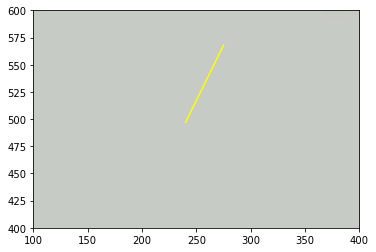

In [10]:
calibrationFrame = frames[0]
fig,ax = plt.subplots(1)
ax.plot([x1,x2],[y1,y2], color = 'yellow')
ax.imshow(calibrationFrame, cmap = 'gray')
plt.xlim(100,400)
plt.ylim(400,600)
plt.show()
sizePIX =  np.sqrt(  (x2 - x1 )**2 + (y2 - y1)**2 )

Fill in the underneath variable the size of the linepiece in meters.

In [11]:
sizeIRL = 0.03 # meters

In [12]:
scale = sizeIRL / sizePIX
print("Scale is " + str(scale) + " meters/pixels")

Scale is 0.0003789885239801462 meters/pixels


In [13]:
def spot_detection_3points(frames,scale,frameRate,reducefps=10,radius=[40],thresh=None,particle_num=1):
    """This script reads frames from a .mp4 file, transforms channels, 
    such that blue and red are mapped to dark, black is mapped to white. 
    Filtering, thresholding, Hough Circle transform
    Final positions are centres of the Hough Circles

    Args:
        file_name (Path) : Path to raw data (.mp4 file)
        shorten   (int, default: 1)  : quotient by which time series is shortened
        reducefps (int, default: 12)  : every Nth step only used, 
        radius (list of int, default: [30,32]) : Radii to test for Hough transform

    Returns:
        pandas Dataframe: with positions 'x','y' and time 'frame','t'
    """
    x=[]
    y=[]
    xg=[]
    xb=[]
    yg=[]
    yb=[]
    radii=[]
    a=[]
    t=[]
    iL = []
    
    timePerFrame = (1/frameRate)*reducefps
    for i in range(0,int(len(frames)),reducefps):
        iL.append(i)
        r,gr,b = frames[i][:,:,0],frames[i][:,:,1],frames[i][:,:,2]
        red=(abs((r/np.max(r))-(gr/np.max(gr)))+abs((gr/np.max(gr))-(b/np.max(b)))+abs((r/np.max(r))-(b/np.max(b)))) #map colors to red -> white, else->black
        gre=(abs((gr/np.max(gr))-(r/np.max(r)))-abs((r/np.max(r))-(b/np.max(b)))+abs((gr/np.max(gr))-(b/np.max(b)))) #map colors to set green -> white
        blu=-abs((gr/np.max(gr))-(r/np.max(r)))+abs((r/np.max(r))-(b/np.max(b)))+abs((gr/np.max(gr))-(b/np.max(b))) #map colors to set blue -> white
        red = filters.gaussian(red,sigma=2)
        
        if thresh is None:
            thresh = skimage.filters.threshold_otsu(red)
        binary_red = np.zeros(np.shape(red))
        binary_red[red>thresh]=1   
        
        
        area = np.sum(binary_red)/particle_num
        
        if radius is None:
            radius = [np.sqrt(area/np.pi)] #create radius by the pixle size of the masked object

        circles = transform.hough_circle(binary_red,radius=radius)
        accums, cx, cy, rad = transform.hough_circle_peaks(circles, radius, total_num_peaks=particle_num)

        #check blue and green channels
        for j,im in enumerate([gre,blu]):
            im = filters.gaussian(im,sigma=3)
            im_mask = np.zeros(np.shape(im))
            for cxi,cyi in zip(cx,cy):
                im_mask[np.max([0,int(cyi-radius)]):np.min([int(cyi+radius),np.shape(im)[0]]),np.max([0,int(cxi-radius)]):np.min([int(cxi+radius),np.shape(im)[0]])]=1 #look only around partice positions
            im*=im_mask
            thresh_peak = filters.threshold_otsu(im)
            
            
#             plt.figure()
#             plt.imshow(im)
#             plt.show()
            
            
            coord = peak_local_max(im, min_distance=int(radius[0]),threshold_abs=thresh_peak,num_peaks=particle_num)
            
            
#             print(coord)
#             plt.figure()
#             plt.imshow(im[:200,800:1000])
#             plt.plot(coord[0,1]-800,coord[0,0],marker='*',color='r')
#             plt.show()
            
            
            if j==0:
                xg.extend(coord[:,1])
                yg.extend(coord[:,0])
            else:
                xb.extend(coord[:,1])
                yb.extend(coord[:,0])
            
        x.extend(cx)
        y.extend(cy)
        radii.extend(rad)
        a.extend(accums)
        t.extend([i/reducefps]*particle_num)
    
#     print(t)

#     print(len(y))
    p = pd.DataFrame({'y': [*y],
                      'x': [*x],
                      'xb': [*xb],
                      'xg': [*xg],
                      'yb': [*yb],
                      'yg': [*yg],
                      'frame': iL ,
                      't': [*t]})
    p['t'] = p['t']*timePerFrame
    p['y'] = p['y']*scale
    p['x'] = p['x']*scale
    p['yg'] = p['yg']*scale
    p['yb'] = p['yb']*scale
    p['xg'] = p['xg']*scale
    p['xb'] = p['xb']*scale
    
    return p

In [14]:
data = spot_detection_3points(frames,scale, frameRate,  thresh = 0.9,radius = None, reducefps=2)

In [15]:
data

,y,x,xb,xg,yb,yg,frame,t
0,0.247101,0.137952,0.129614,0.146290,0.251648,0.248616,0,0.000000
1,0.247858,0.138710,0.132646,0.144395,0.255438,0.244827,2,0.066667
2,0.247858,0.140226,0.135299,0.141742,0.257333,0.242553,4,0.133333
3,0.247858,0.140984,0.139089,0.138331,0.258091,0.242174,6,0.200000
4,0.247858,0.141363,0.141742,0.136057,0.257333,0.242174,8,0.266667
5,0.247480,0.141363,0.144016,0.132267,0.255438,0.244069,10,0.333333
6,0.247101,0.141742,0.146669,0.130372,0.253164,0.247101,12,0.400000
7,0.247101,0.138331,0.147806,0.129993,0.250132,0.250132,14,0.466667
8,0.247858,0.139468,0.146290,0.131509,0.245585,0.253922,16,0.533333
9,0.247858,0.140605,0.144395,0.134541,0.243311,0.256196,18,0.600000


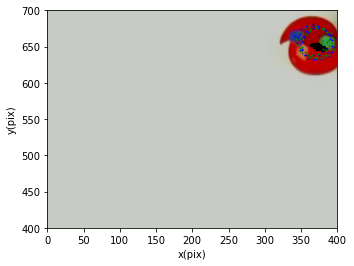

In [16]:
fig, ax = plt.subplots()
ax.scatter(data['x']*(1/scale), data['y']*(1/scale), s = 5, color = 'black')
ax.scatter(data['xb']*(1/scale), data['yb']*(1/scale),s = 0.9, color = 'blue')
ax.scatter( data['xg']*(1/scale),data['yg']*(1/scale), s = 0.9, color = 'green')
ax.set_xlabel('x(pix)')
ax.set_ylabel('y(pix)')
ax.set_aspect('equal')
ax.set_xlim(0,400)
ax.set_ylim(400,700)
plt.imshow(frames[0])

Text(0, 0.5, 'y (m)')

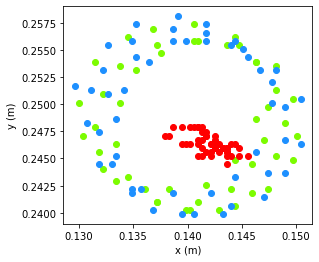

In [17]:
fig, ax = plt.subplots()
ax.scatter(data['xg'], data['yg'], color = 'lawngreen')
ax.scatter(data['xb'], data['yb'], color = 'dodgerblue')
ax.scatter(data['x'], data['y'], color = 'red')
ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('x (m)')
ax.set_ylabel('y (m)')

[]

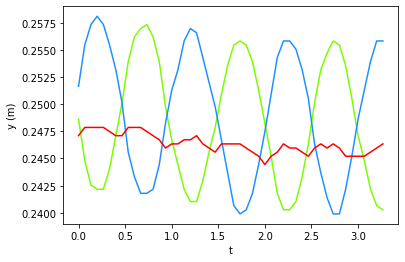

In [18]:
plt.plot(data['t'],data['yg'], color = 'lawngreen')
plt.plot(data['t'],data['yb'], color = 'dodgerblue')
plt.plot(data['t'],data['y'], color = 'red')
plt.xlabel('t')
plt.ylabel('y (m)')
plt.plot()

[]

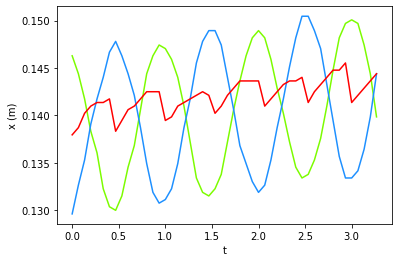

In [19]:
plt.plot(data['t'],data['xg'], color = 'lawngreen')
plt.plot(data['t'],data['xb'], color = 'dodgerblue')
plt.plot(data['t'],data['x'], color = 'red')
plt.xlabel('t')
plt.ylabel('x (m)')
plt.plot()

Text(0, 0.5, 'y (m)')

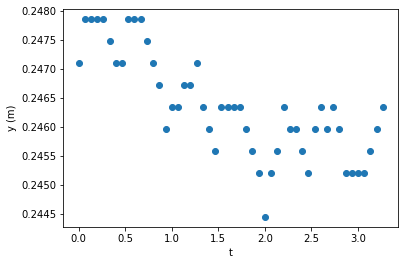

In [20]:
plt.scatter(data['t'], data['y'])
plt.xlabel('t')
plt.ylabel("y (m)")

In [21]:
# data['xminb'] = data['xb']- data['x']
# data['yminb'] = data['yb']- data['y']
# data['xming'] = data['xg']- data['x']
# data['yming'] = data['yg']- data['y']

data['ycenb'] = data['yb'] - data['yg']
data['xcenb'] = data['xb'] - data['xg']

data

,y,x,xb,xg,yb,yg,frame,t,ycenb,xcenb
0,0.247101,0.137952,0.129614,0.146290,0.251648,0.248616,0,0.000000,0.003032,-0.016675
1,0.247858,0.138710,0.132646,0.144395,0.255438,0.244827,2,0.066667,0.010612,-0.011749
2,0.247858,0.140226,0.135299,0.141742,0.257333,0.242553,4,0.133333,0.014781,-0.006443
3,0.247858,0.140984,0.139089,0.138331,0.258091,0.242174,6,0.200000,0.015918,0.000758
4,0.247858,0.141363,0.141742,0.136057,0.257333,0.242174,8,0.266667,0.015160,0.005685
5,0.247480,0.141363,0.144016,0.132267,0.255438,0.244069,10,0.333333,0.011370,0.011749
6,0.247101,0.141742,0.146669,0.130372,0.253164,0.247101,12,0.400000,0.006064,0.016297
7,0.247101,0.138331,0.147806,0.129993,0.250132,0.250132,14,0.466667,0.000000,0.017812
8,0.247858,0.139468,0.146290,0.131509,0.245585,0.253922,16,0.533333,-0.008338,0.014781
9,0.247858,0.140605,0.144395,0.134541,0.243311,0.256196,18,0.600000,-0.012886,0.009854


Text(0, 0.5, 'y (m)')

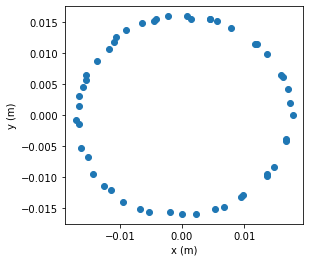

In [22]:
fig, ax = plt.subplots()

ax.scatter(data['xcenb'],data['ycenb'])
ax.set_aspect('equal')
plt.xlabel('x (m)')
plt.ylabel('y (m)')
# plt.scatter(data['xtest'],data['ytest'])

In [23]:
data['theta'] = (np.arctan2(data['ycenb'],data['xcenb']))

# in degree to make more sense if we quickly look at it
# data['theta'] = np.degrees(np.arctan(data['ycenb']/data['xcenb']))
data

,y,x,xb,xg,yb,yg,frame,t,ycenb,xcenb,theta
0,0.247101,0.137952,0.129614,0.146290,0.251648,0.248616,0,0.000000,0.003032,-0.016675,2.961739
1,0.247858,0.138710,0.132646,0.144395,0.255438,0.244827,2,0.066667,0.010612,-0.011749,2.406998
2,0.247858,0.140226,0.135299,0.141742,0.257333,0.242553,4,0.133333,0.014781,-0.006443,1.981861
3,0.247858,0.140984,0.139089,0.138331,0.258091,0.242174,6,0.200000,0.015918,0.000758,1.523213
4,0.247858,0.141363,0.141742,0.136057,0.257333,0.242174,8,0.266667,0.015160,0.005685,1.212026
5,0.247480,0.141363,0.144016,0.132267,0.255438,0.244069,10,0.333333,0.011370,0.011749,0.769006
6,0.247101,0.141742,0.146669,0.130372,0.253164,0.247101,12,0.400000,0.006064,0.016297,0.356220
7,0.247101,0.138331,0.147806,0.129993,0.250132,0.250132,14,0.466667,0.000000,0.017812,0.000000
8,0.247858,0.139468,0.146290,0.131509,0.245585,0.253922,16,0.533333,-0.008338,0.014781,-0.513606
9,0.247858,0.140605,0.144395,0.134541,0.243311,0.256196,18,0.600000,-0.012886,0.009854,-0.917950


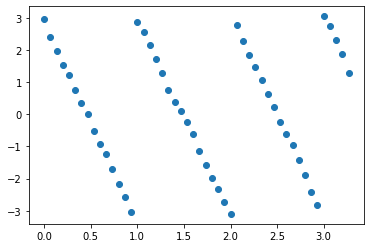

In [24]:
plt.scatter(data['t'],data['theta'])

Determine velocities

In [28]:
data['dtheta'] = data['theta'].diff(periods = 1)

# angularvelocity in radians per frame (if time variable get inserted in code we can adjust is to time)
data['w'] = data['dtheta'] / 0.066667

data

,y,x,xb,xg,yb,yg,frame,t,ycenb,xcenb,theta,dtheta,w,diameter,r
0,0.247101,0.137952,0.129614,0.146290,0.251648,0.248616,0,0.000000,0.003032,-0.016675,2.961739,NaN,NaN,0.016949,0.008474
1,0.247858,0.138710,0.132646,0.144395,0.255438,0.244827,2,0.066667,0.010612,-0.011749,2.406998,-0.554741,-8.321073,0.015832,0.007916
2,0.247858,0.140226,0.135299,0.141742,0.257333,0.242553,4,0.133333,0.014781,-0.006443,1.981861,-0.425137,-6.377028,0.016124,0.008062
3,0.247858,0.140984,0.139089,0.138331,0.258091,0.242174,6,0.200000,0.015918,0.000758,1.523213,-0.458648,-6.879680,0.015936,0.007968
4,0.247858,0.141363,0.141742,0.136057,0.257333,0.242174,8,0.266667,0.015160,0.005685,1.212026,-0.311188,-4.667790,0.016190,0.008095
5,0.247480,0.141363,0.144016,0.132267,0.255438,0.244069,10,0.333333,0.011370,0.011749,0.769006,-0.443019,-6.645259,0.016349,0.008175
6,0.247101,0.141742,0.146669,0.130372,0.253164,0.247101,12,0.400000,0.006064,0.016297,0.356220,-0.412787,-6.191767,0.017388,0.008694
7,0.247101,0.138331,0.147806,0.129993,0.250132,0.250132,14,0.466667,0.000000,0.017812,0.000000,-0.356220,-5.343268,0.017812,0.008906
8,0.247858,0.139468,0.146290,0.131509,0.245585,0.253922,16,0.533333,-0.008338,0.014781,-0.513606,-0.513606,-7.704052,0.016970,0.008485
9,0.247858,0.140605,0.144395,0.134541,0.243311,0.256196,18,0.600000,-0.012886,0.009854,-0.917950,-0.404344,-6.065125,0.016221,0.008111


Radius/diameter compared to centre

In [26]:
# data['radb'] = np.sqrt((data['xb']-data['x'])**2 + (data['yb']-data['y'])**2)
# data['radg'] = np.sqrt((data['xg']-data['x'])**2 + (data['yg']-data['y'])**2)
# data['diameter'] = np.sqrt((data['xb']-data['xg'])**2 + (data['yb']-data['yg'])**2)
# data

Diameter 

In [27]:
## with x and y from blue and green dot
# data['diameter'] = np.sqrt((data['xb']-data['xg'])**2 + (data['yb']-data['yg'])**2)

# with radius of blue dot centred around green dot 

data['diameter'] = np.sqrt((data['xcenb']**2 + (data['ycenb'])**2))
data['r'] = data['diameter']/2
data

,y,x,xb,xg,yb,yg,frame,t,ycenb,xcenb,theta,dtheta,w,diameter,r
0,0.247101,0.137952,0.129614,0.146290,0.251648,0.248616,0,0.000000,0.003032,-0.016675,2.961739,NaN,NaN,0.016949,0.008474
1,0.247858,0.138710,0.132646,0.144395,0.255438,0.244827,2,0.066667,0.010612,-0.011749,2.406998,-0.554741,-0.554741,0.015832,0.007916
2,0.247858,0.140226,0.135299,0.141742,0.257333,0.242553,4,0.133333,0.014781,-0.006443,1.981861,-0.425137,-0.425137,0.016124,0.008062
3,0.247858,0.140984,0.139089,0.138331,0.258091,0.242174,6,0.200000,0.015918,0.000758,1.523213,-0.458648,-0.458648,0.015936,0.007968
4,0.247858,0.141363,0.141742,0.136057,0.257333,0.242174,8,0.266667,0.015160,0.005685,1.212026,-0.311188,-0.311188,0.016190,0.008095
5,0.247480,0.141363,0.144016,0.132267,0.255438,0.244069,10,0.333333,0.011370,0.011749,0.769006,-0.443019,-0.443019,0.016349,0.008175
6,0.247101,0.141742,0.146669,0.130372,0.253164,0.247101,12,0.400000,0.006064,0.016297,0.356220,-0.412787,-0.412787,0.017388,0.008694
7,0.247101,0.138331,0.147806,0.129993,0.250132,0.250132,14,0.466667,0.000000,0.017812,0.000000,-0.356220,-0.356220,0.017812,0.008906
8,0.247858,0.139468,0.146290,0.131509,0.245585,0.253922,16,0.533333,-0.008338,0.014781,-0.513606,-0.513606,-0.513606,0.016970,0.008485
9,0.247858,0.140605,0.144395,0.134541,0.243311,0.256196,18,0.600000,-0.012886,0.009854,-0.917950,-0.404344,-0.404344,0.016221,0.008111
